It's often said that deep learning models are black boxes. The representations learned by neural network are not in human readable form. Although it is partially true for certain types of deep-learning models, it's definitely not true for convnets. The presentations learned by convnets are highly amenable to visualization. There are different techniques for visualizing and interpreting these representations, some of them are:

1. Visualizing the intermediate convnet outputs(Intermediate activations).
2. Visualizing convnet filters.
3. Visualizing the heatmaps of class activation in an image.

In this notebook we will build a basic convolutional neural network for single-label binary-classification task and visualize the intermediate activations of CNN.


Let's start with importing necessary packages and initializing the parameters.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.image as mpimg
import cv2
import re
from collections import Counter
import os

In [10]:
BASE_DIR = "../input/dogs-vs-cats"
TRAIN_DIR = BASE_DIR + '/train/train'
TEST_DIR = BASE_DIR + '/test/test'
IMAGE_SIZE = (150,150)
BATCH_SIZE = 20
EPOCHS = 30
SPLIT_INDEX = 23000
RANDOM_SEED = 6587

#ImageDataGenerator
DATAGEN = ImageDataGenerator(
                rescale = 1.0/255
                )

Let's start with creating a dataframe with filenames and their corresponding labels. Later we will split this dataframe into train and validation dataframes. We will use ImageDataGenerator with flow_from_dataframe to get the data to our model.

In [11]:
def get_images_labels(directory):
    
    images = []
    labels = []
    
    for file in os.listdir(directory):
        
        #get the label from file name
        label = file.split('.')[0]
        images.append(file)
        labels.append(label)
        
    return images, labels

In [12]:
#get image path and label
train_images, train_labels = get_images_labels(TRAIN_DIR)

#store data in pandas dataframe for easy processing
df = pd.DataFrame({'image':train_images, 'label':train_labels})

#shuffle data
df = df.sample(frac=1, random_state=RANDOM_SEED)

#find count for each class
print(df['label'].value_counts())

dog    12500
cat    12500
Name: label, dtype: int64


Let's display some of the images

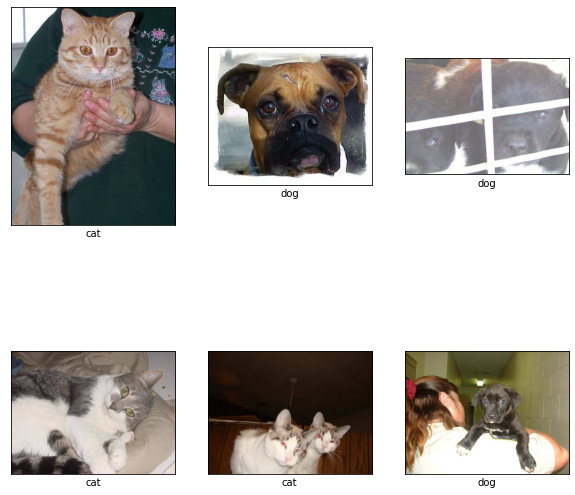

In [13]:
def plot_random_images(nb_rows, nb_cols, df, figsize=(10,10)):
    nb_images = nb_rows*nb_cols
    idx = np.random.choice(len(df), size=(nb_images))
    j=0
    fig=plt.figure(figsize=figsize)
    for i in idx:
            img = mpimg.imread(TRAIN_DIR+'/'+df['image'][i])
            fig.add_subplot(nb_rows,nb_cols,j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(img, cmap=plt.cm.binary)
            plt.xlabel(df['label'][i])
            j += 1
    plt.show()
plot_random_images(2,3,df)

## Train-Val split

In [14]:
df_train = df[:SPLIT_INDEX].reset_index(drop=True)
df_val = df[SPLIT_INDEX:].reset_index(drop=True)

In [15]:
train_datagen = DATAGEN.flow_from_dataframe(
                dataframe = df_train,
                directory = TRAIN_DIR,
                x_col = 'image',
                y_col = 'label',
                target_size = IMAGE_SIZE,
                class_mode = 'binary',
                batch_size = BATCH_SIZE
                )

val_datagen = DATAGEN.flow_from_dataframe(
                dataframe = df_val,
                directory = TRAIN_DIR,
                x_col = 'image',
                y_col = 'label',
                target_size = IMAGE_SIZE,
                class_mode = 'binary',
                batch_size = BATCH_SIZE
                )

Found 23000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


## Model

In [17]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer=optimizers.Nadam(lr=2e-5), metrics=['acc'] )

In [18]:
history = model.fit_generator(
                                train_datagen,
                                steps_per_epoch = train_datagen.samples // BATCH_SIZE,
                                epochs = EPOCHS,
                                validation_data = val_datagen,
                                validation_steps = val_datagen.samples // BATCH_SIZE,
                             )

Epoch 1/30
1150/1150 [==============================] - 118s 102ms/step - loss: 0.6720 - acc: 0.5790 - val_loss: 0.6440 - val_acc: 0.6110
Epoch 2/30
1150/1150 [==============================] - 79s 69ms/step - loss: 0.6148 - acc: 0.6587 - val_loss: 0.6388 - val_acc: 0.6305
Epoch 3/30
1150/1150 [==============================] - 79s 69ms/step - loss: 0.5633 - acc: 0.7086 - val_loss: 0.5421 - val_acc: 0.7340
Epoch 4/30
1150/1150 [==============================] - 77s 67ms/step - loss: 0.5311 - acc: 0.7347 - val_loss: 0.5210 - val_acc: 0.7480
Epoch 5/30
1150/1150 [==============================] - 76s 66ms/step - loss: 0.5103 - acc: 0.7527 - val_loss: 0.5057 - val_acc: 0.7550
Epoch 6/30
1150/1150 [==============================] - 78s 68ms/step - loss: 0.4934 - acc: 0.7601 - val_loss: 0.4884 - val_acc: 0.7720
Epoch 7/30
1150/1150 [==============================] - 77s 67ms/step - loss: 0.4778 - acc: 0.7732 - val_loss: 0.4727 - val_acc: 0.7785
Epoch 8/30
1150/1150 [========================

We have trained a model with validation accuracy of 86%, it can be further improved by using pretrained models, fine tuning, augmentation etc. Since here our objective is to visualize the intermediate activations, I will stop the training here. Let's go on to visualization part.

Let's take a random image from test set and proprocess it to pass through the trained model, we will save the activation outputs of initial 4 layers in a list and visualize it.

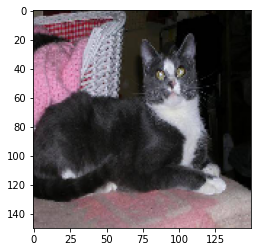

In [49]:
#path to test image
path = "../input/dogs-vs-cats/test/test/10103.jpg"

#preprocess the image
img = image.load_img(path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

#show image
plt.imshow(img_tensor[0])
plt.show()

In [50]:
#model that outputs activations
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

#apply model on test image(preprocessed)
activations = activation_model.predict(img_tensor)

Now that we have activation values with us, let's visualize them.

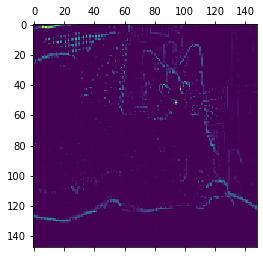

In [59]:
# plot 1 channel activations of first layer of trained model
plt.matshow(activations[0][0,:,:,1], cmap='viridis')

This channel appears to encode an edge detector.

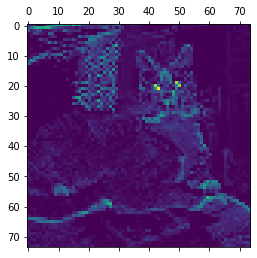

In [98]:
# plot 2 channel activations of second layer of trained model
plt.matshow(activations[1][0,:,:,2], cmap='viridis')

Channels of layer 2  has learned a bit more complex representations, looks like a combination of edge and eye detector.

Let's see representataions of initial 8 layers.

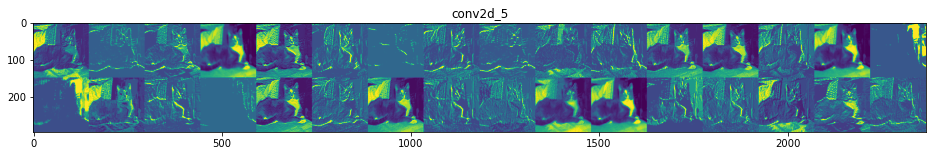

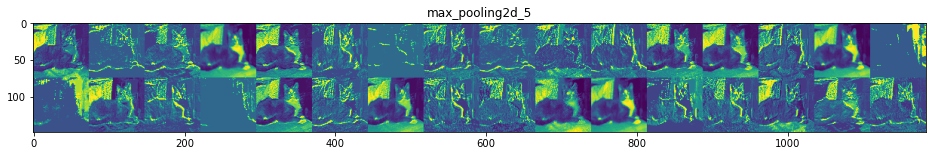

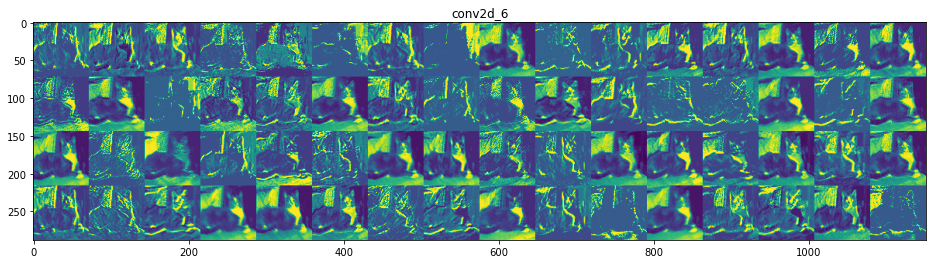

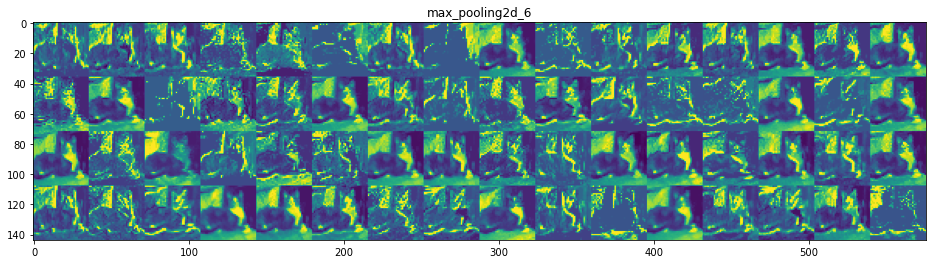

In [101]:
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    n_cols = n_features//images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image +=128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size: (col+1)*size,
                         row*size: (row+1)*size] = channel_image
        
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

We can see that higher representations carry less information about the visual contents of the image and more related to the class of image.

My other kernels on CV:

[Fine tuning VGG16](https://www.kaggle.com/flygirl/intel-image-classification-90-fine-tuning-vgg16)